# MNIST

In [1]:
import datetime, os
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# from keras_tqdm import TQDMNotebookCallback
# keras-tqdm does not work at 2024. Because keras_tqdm doesn't catch up the change of package structure of the TensorFlow 2.2.

# Parameters
NB_EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10
OPTIMIZER = SGD()
N_HIDDEN = 128
VALIDATION_SPLIT = 0.2

# random seed for reproducibility
np.random.seed(1671)

2024-03-25 15:43:41.636624: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 15:43:41.664607: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 15:43:41.664627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 15:43:41.664645: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 15:43:41.671948: I tensorflow/core/platform/cpu_feature_g

## 手書きの数字の画像を読み込む
- 28x28 の白黒画像
- 輝度は 0～255

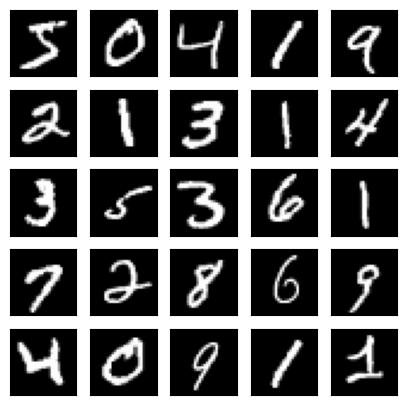

In [2]:

# Load MNIST dataset from Keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

W = 5
H = 5
fig = plt.figure(figsize=(H, W))
for i in range(W*H):
    ax = fig.add_subplot(H, W, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i].reshape((28, 28)), cmap='gray')

plt.show()

## データの整形
- 28x28 の２次元データを 784 の １次元データに変換
- 画素を 0~255 ではなく 0～1 にする
- 画像に対応する数値ラベルは one-hot 形式にする
```python
 1 = [1,0,0,0,0,0,0,0,0,0]
 2 = [0,1,0,0,0,0,0,0,0,0]
 3 = [0,0,1,0,0,0,0,0,0,0]
 4 = [0,0,0,1,0,0,0,0,0,0]
 5 = [0,0,0,0,1,0,0,0,0,0]
 6 = [0,0,0,0,0,1,0,0,0,0]
 7 = [0,0,0,0,0,0,1,0,0,0]
 8 = [0,0,0,0,0,0,0,1,0,0]
 9 = [0,0,0,0,0,0,0,0,1,0]
 0 = [0,0,0,0,0,0,0,0,0,1]
```
- → 予測は、確率分布になる。下の場合は 5 の確率が 80%
```python
 y = [0.01, 0.02, 0.00, 0.00, 0.80, 0.00, 0.10, 0.01, 0.04, 0.01]
```

In [3]:
# X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 28 * 28
X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize
X_train /= 255.0
X_test /= 255.0

# Convert class vectors to binary class matrices
Y_train = to_categorical(y_train, NB_CLASSES)
Y_test = to_categorical(y_test, NB_CLASSES)

print('X_train' , X_train.shape)
print('X_test ' , X_test.shape)
print('Y_train' , Y_train.shape)
print('Y_test ' , Y_test.shape)

print('X_train[0]', X_train[0][100:200])
print('Y_train[0]', Y_train[0])

X_train (60000, 784)
X_test  (10000, 784)
Y_train (60000, 10)
Y_test  (10000, 10)
X_train[0] [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01176471 0.07058824
 0.07058824 0.07058824 0.49411765 0.53333336 0.6862745  0.10196079
 0.6509804  1.         0.96862745 0.49803922 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11764706 0.14117648
 0.36862746 0.6039216  0.6666667  0.99215686 0.99215686 0.99215686
 0.99215686 0.99215686 0.88235295 0.6745098  0.99

## ネットワークを作る
- 入力は 786 (=RESHAPED) 
- 出力は 10 (=NB_CLASS) クラス
- 出力は Softmax (K次元の確率分布にする。各要素 0～1で、合計1)

In [4]:
model = Sequential()
model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
model.add(Activation('relu'))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               1

In [5]:
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

history = model.fit(X_train, Y_train
          , batch_size=BATCH_SIZE
          , epochs=NB_EPOCH
          , verbose=VERBOSE
          , validation_split=VALIDATION_SPLIT
          , callbacks=[tensorboard_callback])

score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Epoch 1/20


2024-03-25 15:43:48.868445: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f60b4136780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-25 15:43:48.868482: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA T550 Laptop GPU, Compute Capability 7.5
2024-03-25 15:43:49.031245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-03-25 15:43:49.080391: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 [==============================] - 5s 8ms/step - loss: 1.7964 - accuracy: 0.5422 - val_loss: 0.8792 - val_accuracy: 0.8078
Epoch 2/20
375/375 [==============================] - 3s 7ms/step - loss: 0.6005 - accuracy: 0.8347 - val_loss: 0.4226 - val_accuracy: 0.8817
Epoch 3/20
375/375 [==============================] - 3s 7ms/step - loss: 0.4088 - accuracy: 0.8815 - val_loss: 0.3411 - val_accuracy: 0.8994
Epoch 4/20
375/375 [==============================] - 3s 7ms/step - loss: 0.3457 - accuracy: 0.8991 - val_loss: 0.3012 - val_accuracy: 0.9121
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 0.3077 - accuracy: 0.9100 - val_loss: 0.2732 - val_accuracy: 0.9233
Epoch 6/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2798 - accuracy: 0.9190 - val_loss: 0.2487 - val_accuracy: 0.9281
Epoch 7/20
375/375 [==============================] - 3s 7ms/step - loss: 0.2576 - accuracy: 0.9243 - val_loss: 0.2362 - val_accuracy: 0.9327
Epoch 8/20
375/37

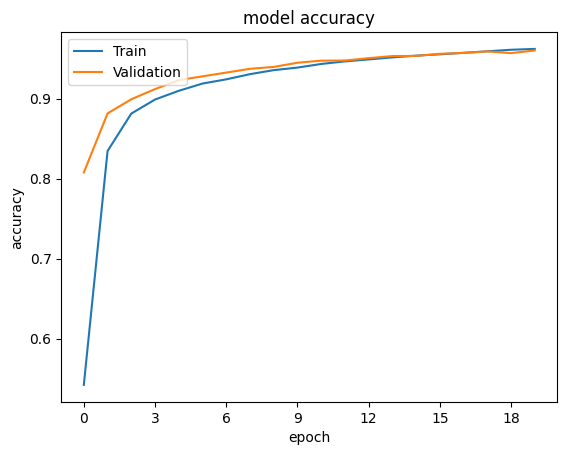

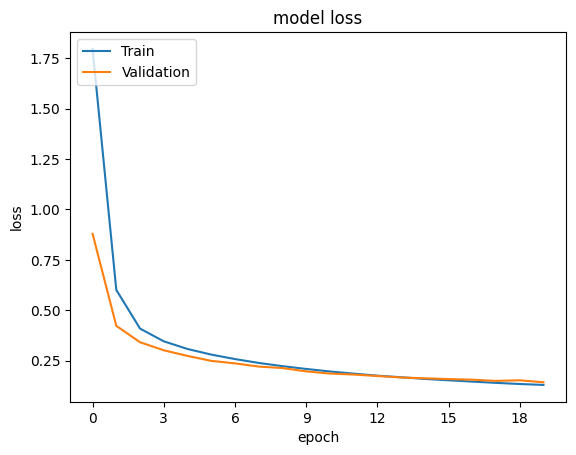

In [6]:
# summarize history for accuracy

fig, ax = plt.subplots()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [7]:
%load_ext tensorboard
%tensorboard --logdir logs